In [1]:
%pip install --upgrade pip
%pip install pandas
%pip install numpy
%pip install datetime
%pip install collections
%pip install matplotlib.pyplot
%pip install seaborn
%pip install pyyaml
%pip install jsonlines
%pip install requests
%pip install datasets
%pip install torch
%pip install scikit-learn
%pip install tabulate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 930.6 kB/s eta 0:00:000:00:010m
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [datetime]
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement matplotlib.pyplot (from versions: none)
ERROR: No matching distribution found for matplotlib.pyplot
Note: you may need to restart the kernel to use updated packages.
 

In [2]:
import sys
import os
import json
import pandas as pd
import numpy as np
import ast
import itertools
import random
import copy
from datetime import datetime
from collections import Counter, defaultdict

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append("../")

from src.helpers import io
from src.classes.dataset import Dataset
from src.classes.annotation_set import AnnotationSet

%load_ext autoreload
%autoreload 2

Matplotlib is building the font cache; this may take a moment.
/Users/zoeyki/Desktop/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zoeyki/Desktop/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Dataset + Annotations

In [4]:
# FILL IN:
PATH_TO_DATASET = "../data/automatic_annotations_v0/wildchat4k-raw.json"
DATASET_ID = "wildchat_1m"
PATH_TO_ANNOTATIONS_DIR = "../data/automatic_annotations_v0/gpto3mini-json-wildchat"

In [5]:
# Load dataset (w/o annotations)
dataset = Dataset.load(PATH_TO_DATASET)

# Load annotations into dataset
for fpath in io.listdir_nohidden(PATH_TO_ANNOTATIONS_DIR):
    annotation_set = AnnotationSet.load_automatic(path=fpath, source="automatic_v0")
    dataset.add_annotations(annotation_set)

prompt-multi_turn_relationship: 0 / 10127 failed due to invalid annotations.
prompt-interaction_features: 0 / 10127 failed due to invalid annotations.
turn-sensitive_use_flags: 0 / 10127 failed due to invalid annotations.
turn-topic: 1 / 10127 failed due to invalid annotations.
response-interaction_features: 0 / 10127 failed due to invalid annotations.
prompt-function_purpose: 6 / 10127 failed due to invalid annotations.
prompt-media_format: 0 / 10127 failed due to invalid annotations.
response-media_format: 0 / 10127 failed due to invalid annotations.
response-answer_form: 0 / 10127 failed due to invalid annotations.


### 1. Co-occurrence Matrix for Multi-label Taxonomies
- Analysis by Zoey
- Multi-label prompt: function_purpose, interaction_features
- Multi-label response: media_format, interaction_features
- Multi-label turn: topic, sensitive_use_flags

In [ ]:
outdir = f"../data/annotation_analysis_v0/descriptive_analysis/v1"
os.makedirs(outdir, exist_ok=True)

def make_cooccurrence_matrix(multilabel_pair, level_id, prompt_id, save):
    parsed_data = []
    for key, count in multilabel_pair.items():
        labels = ast.literal_eval(key)
        if len(labels) > 1:  # Skip single-label entries
            parsed_data.append((labels, count))

    all_labels = set()
    for labels, _ in parsed_data:
        all_labels.update(labels)
    all_labels = sorted(all_labels)

    co_occurrence = pd.DataFrame(0, index=all_labels, columns=all_labels)

    for labels, count in parsed_data:
        for label1, label2 in itertools.combinations_with_replacement(labels, 2):
            co_occurrence.loc[label1, label2] += count
            if label1 != label2:
                co_occurrence.loc[label2, label1] += count

    for label in all_labels:
        co_occurrence.loc[label, label] = 0

    plt.figure(figsize=(12, 10))
    sns.heatmap(co_occurrence, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Co-occurrence Matrix of {level_id} - {prompt_id}")
    plt.savefig(f"{outdir}/{save}.png", dpi=300, bbox_inches='tight')
    plt.show()

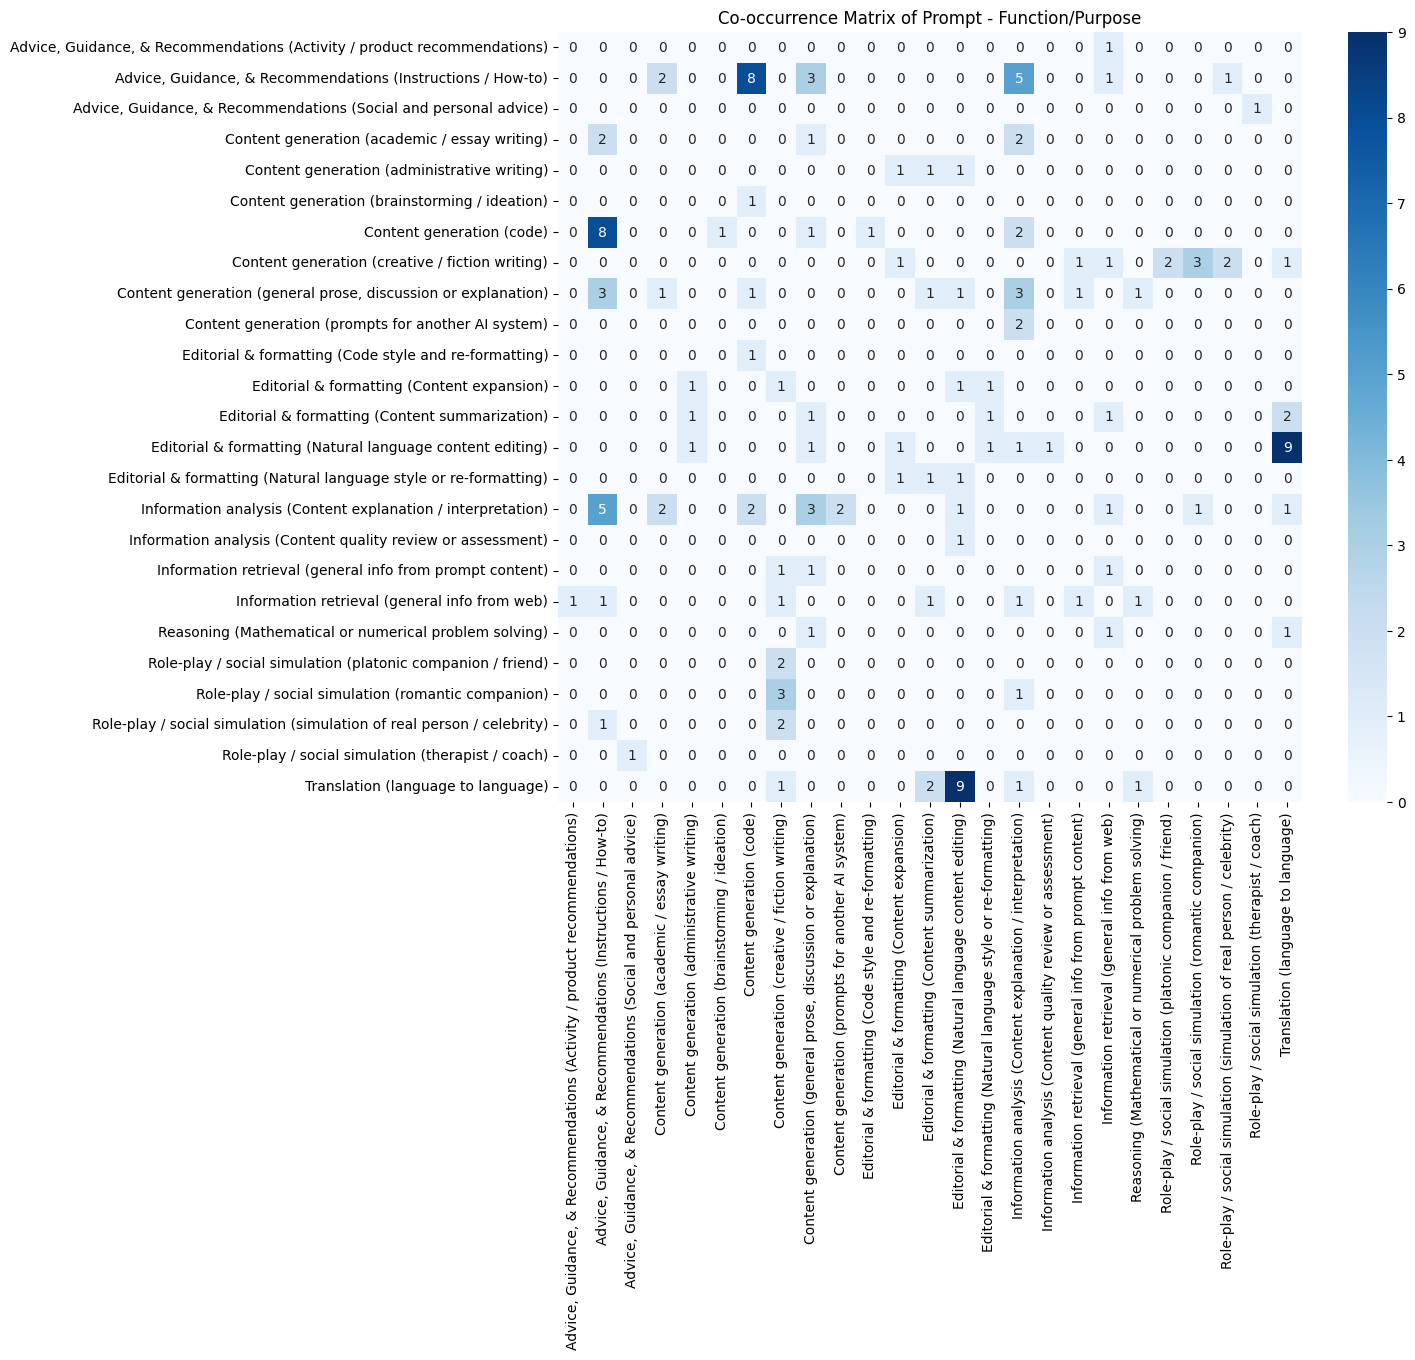

In [24]:
prompt_function_purpose_pairs = dataset.get_annotation_distribution(
    name="prompt_function_purpose",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
# print(prompt_function_purpose_pairs)
make_cooccurrence_matrix(prompt_function_purpose_pairs, "Prompt", "Function/Purpose", "coocurrence_prompt_function_purpose")

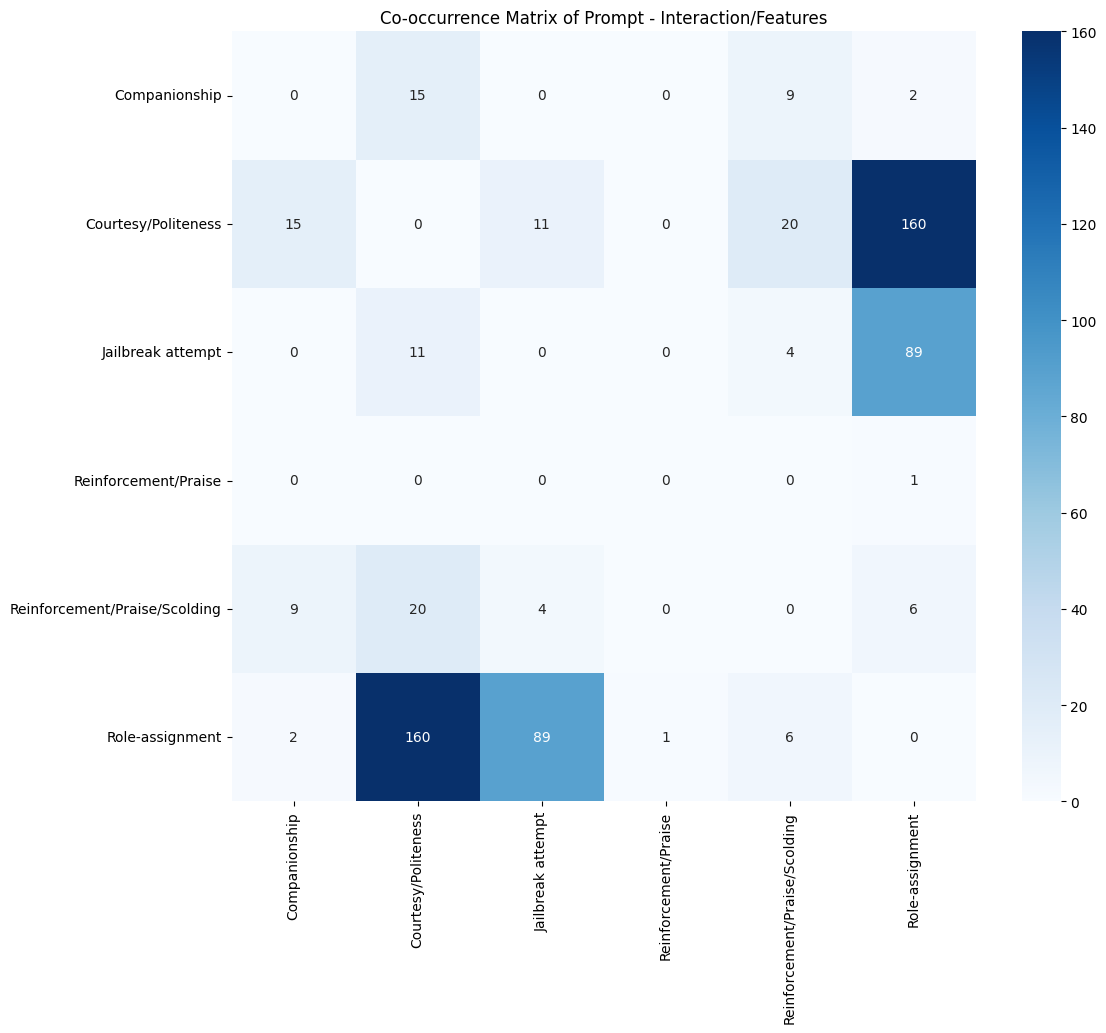

In [15]:
prompt_interaction_features_pairs = dataset.get_annotation_distribution(
    name="prompt_interaction_features",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
# print(prompt_interaction_features_pairs)
make_cooccurrence_matrix(prompt_interaction_features_pairs, "Prompt", "Interaction/Features", "coocurrence_prompt_interaction_features")

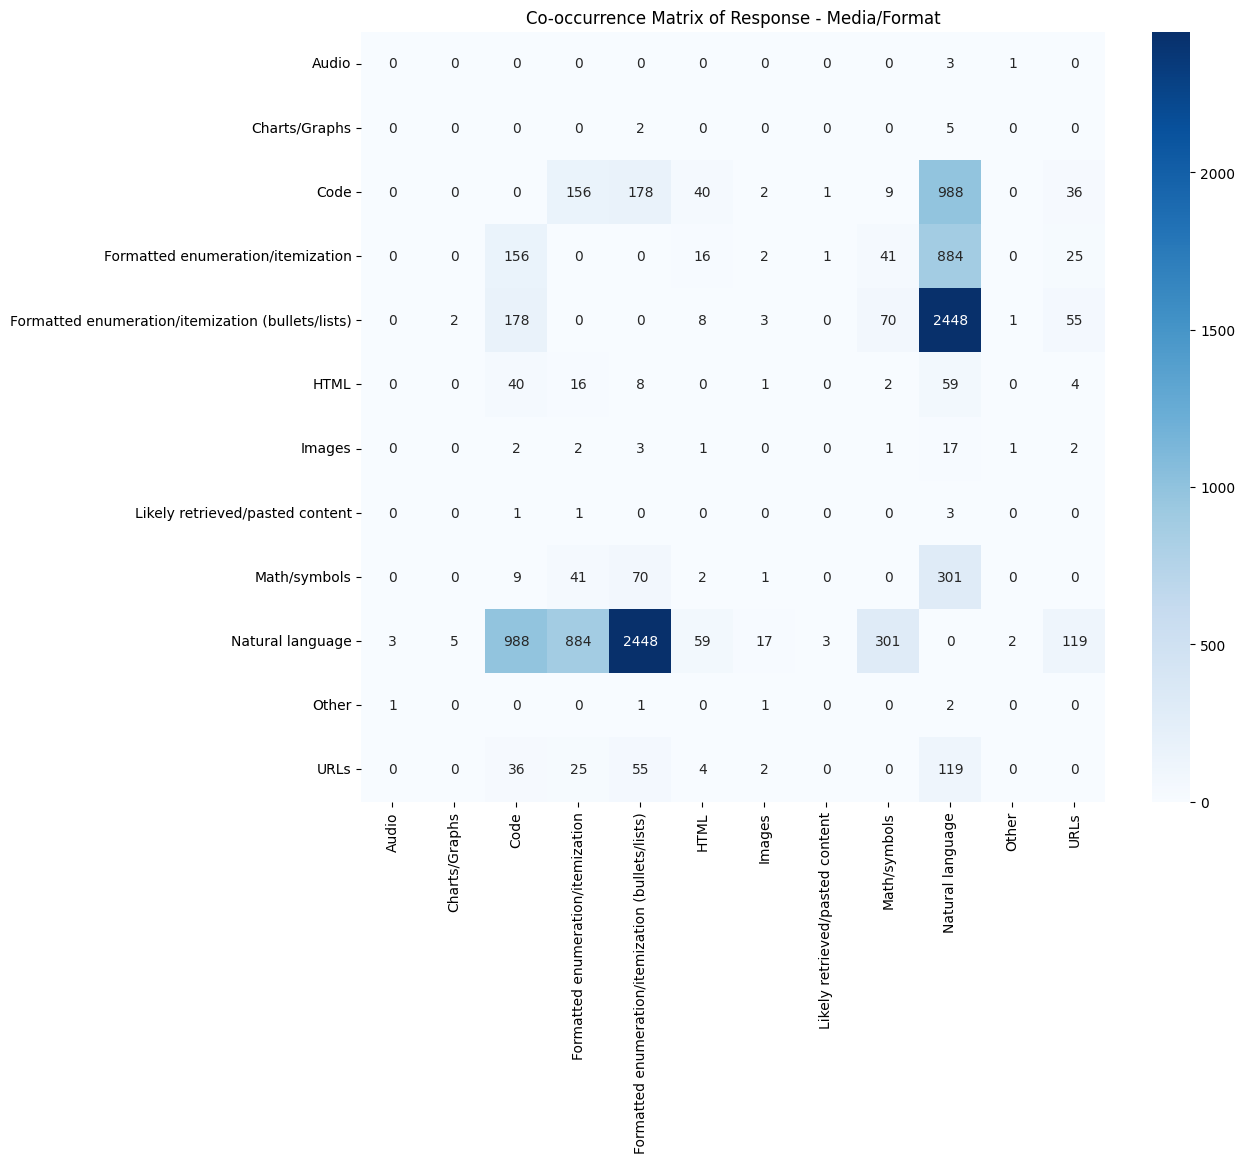

In [16]:
response_media_format_pairs = dataset.get_annotation_distribution(
    name="response_media_format",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
# print(response_media_format_pairs)
make_cooccurrence_matrix(response_media_format_pairs, "Response", "Media/Format", "coocurrence_response_media_format")

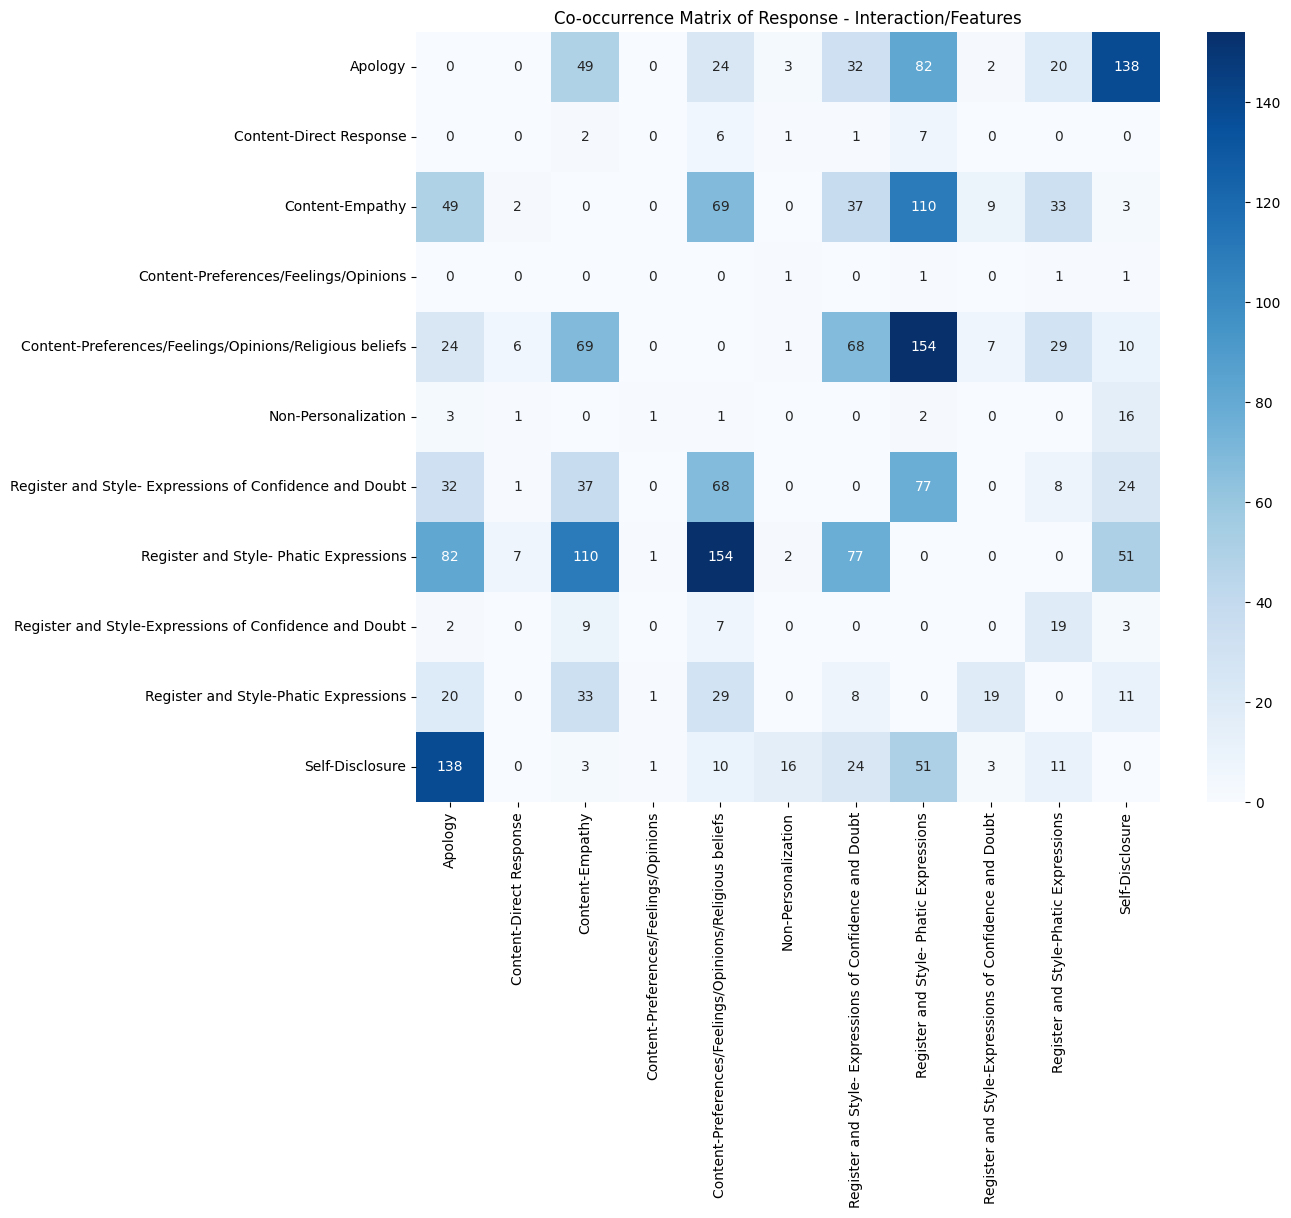

In [25]:
response_interaction_features_pairs = dataset.get_annotation_distribution(
    name="response_interaction_features",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
# print(response_interaction_features_pairs)
make_cooccurrence_matrix(response_interaction_features_pairs, "Response", "Interaction/Features", "coocurrence_response_interaction_features")

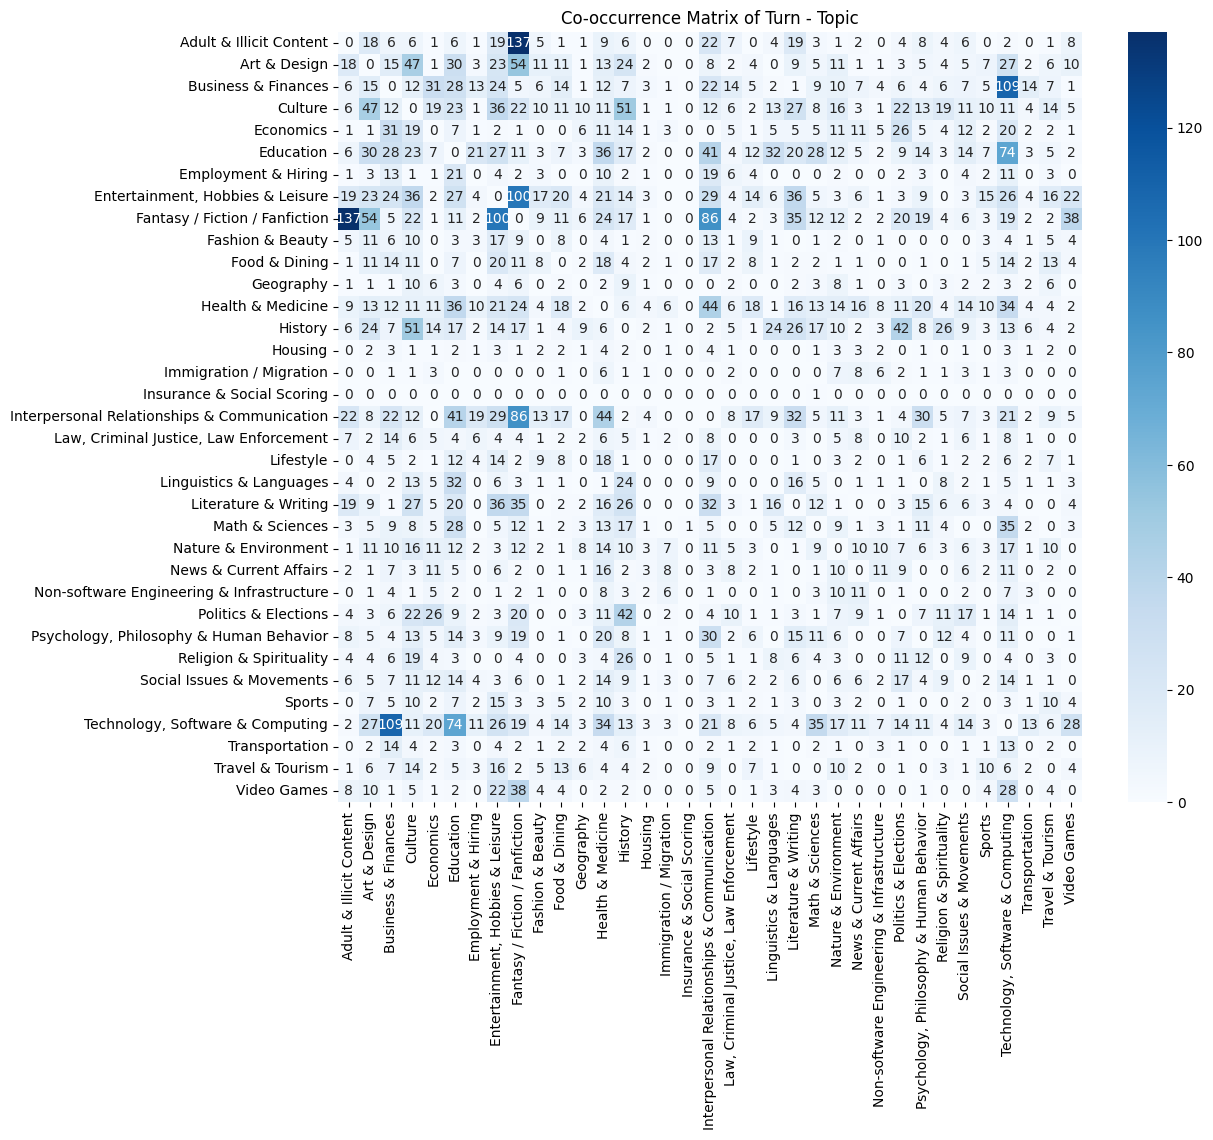

In [17]:
turn_topic_pairs = dataset.get_annotation_distribution(
    name="turn_topic",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=False,
)
# print(turn_topic_pairs)
make_cooccurrence_matrix(turn_topic_pairs, "Turn", "Topic", "cooccurrence_turn_topic")

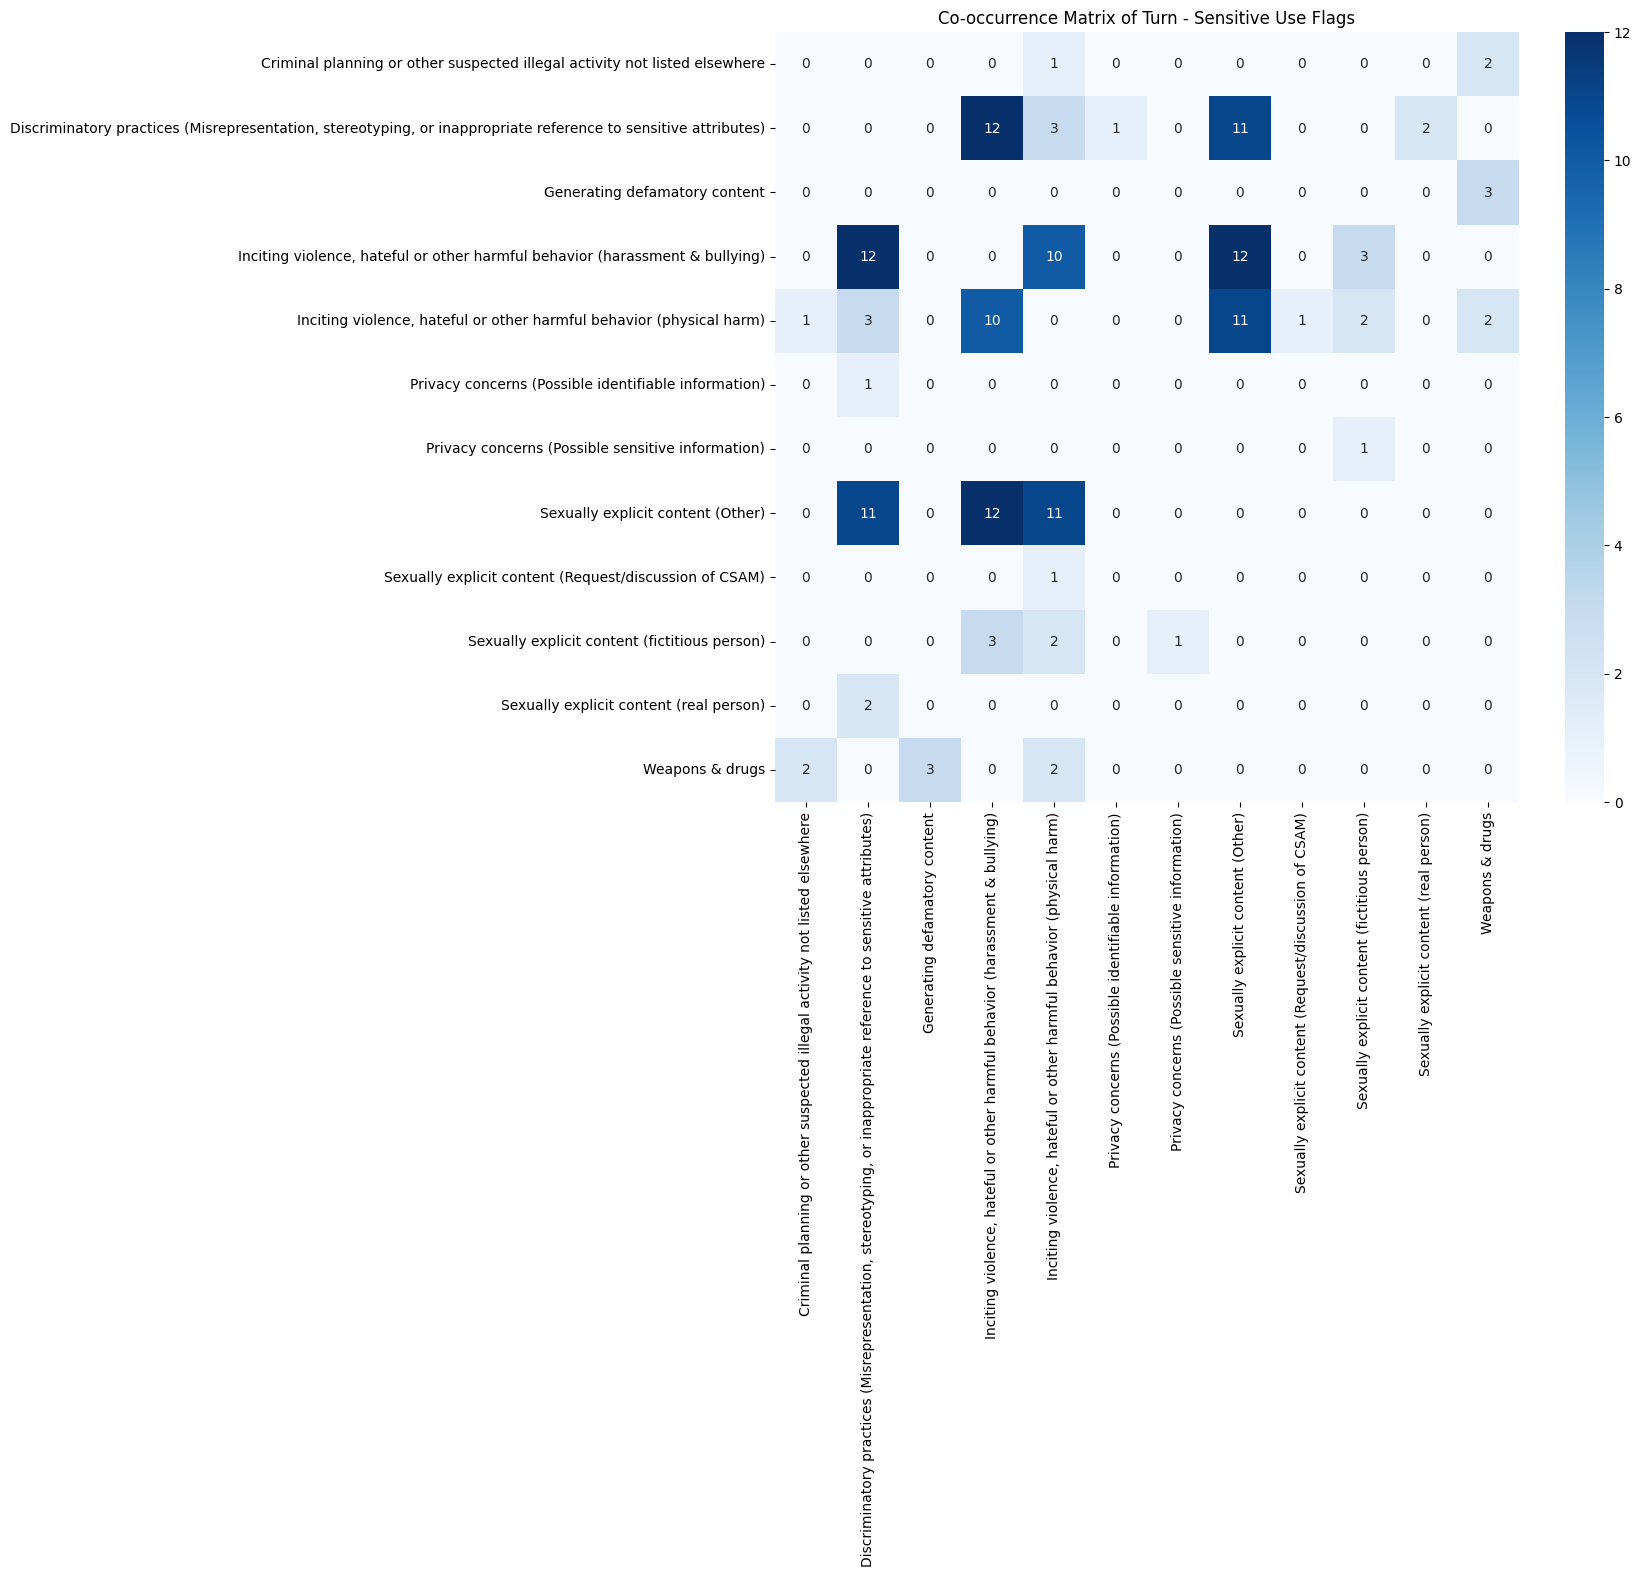

In [18]:
turn_sensitive_use_flags_pairs = dataset.get_annotation_distribution(
    name="turn_sensitive_use_flags",
    level="message",
    annotation_source="automatic_v0",
    annotation_as_list_type=True,
)
# print(turn_sensitive_use_flags_pairs)
make_cooccurrence_matrix(turn_sensitive_use_flags_pairs, "Turn", "Sensitive Use Flags", "cooccurrence_turn_sensitive_use_flags")

### 2. Multi-label Taxonomies Distribution
- Analysis by Zoey
- Q: What is the distribution of number of labels for multi-label taxonomies?

In [32]:
def multilabel_distribution(multilabel_pair):
    label_counts = []
    for key, count in multilabel_pair.items():
        labels = ast.literal_eval(key)
        label_counts.extend([len(labels)] * count)
        # if len(labels) > 1:
        #     label_counts.extend([len(labels)] * count)

    count_distribution = Counter(label_counts)
    sorted_counts = dict(sorted(count_distribution.items()))
    return sorted_counts

In [33]:
# prompt_function_purpose_pairs

In [34]:
multilabel_distribution(prompt_function_purpose_pairs)

{1: 10038, 2: 77}

In [35]:
# prompt_function_purpose_pairs

In [36]:
multilabel_distribution(prompt_interaction_features_pairs)

{1: 9845, 2: 257, 3: 18, 4: 1}

In [37]:
multilabel_distribution(response_media_format_pairs)

{1: 5887, 2: 3685, 3: 500, 4: 47, 5: 2}

In [38]:
multilabel_distribution(response_interaction_features_pairs)

{1: 9370, 2: 607, 3: 121, 4: 22, 5: 1}

In [39]:
multilabel_distribution(turn_topic_pairs)

{1: 8090, 2: 1535, 3: 316, 4: 106, 5: 36, 6: 21, 7: 6, 8: 4, 9: 3, 10: 3}

In [40]:
multilabel_distribution(turn_sensitive_use_flags_pairs)

{1: 10050, 2: 68, 3: 3}

### 3. Distribution of Confidence Labels
- Analysis by Zoey
- Q: What is the distribution of confidence labels per taxonomy?

In [41]:
def plot_confidence_distribution(confidence_dist, level_id, prompt_id, save=None):
    sns.set(style="whitegrid", context="talk", palette="deep")

    bins = list(confidence_dist.keys())
    values = list(confidence_dist.values())

    total = sum(values)
    percentages = [(v / total) * 100 for v in values]

    plt.figure(figsize=(8, 5))
    bars = plt.bar(bins, percentages, width=0.5, color="#4A90E2", edgecolor='black', linewidth=0.7)

    plt.xlabel('Confidence Score (Binned)', fontsize=12)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.title(f"Confidence Label Distribution {level_id} - {prompt_id}", fontsize=14, pad=10)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    for bar, perc in zip(bars, percentages):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{perc:.1f}%', ha='center', va='bottom', fontsize=10)

    plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    plt.tight_layout()

    if save:
        plt.savefig(f"{outdir}/{save}.png", dpi=300, bbox_inches='tight')

    plt.show()


{'0.8': 37, '0.9': 947, '1.0': 13928}


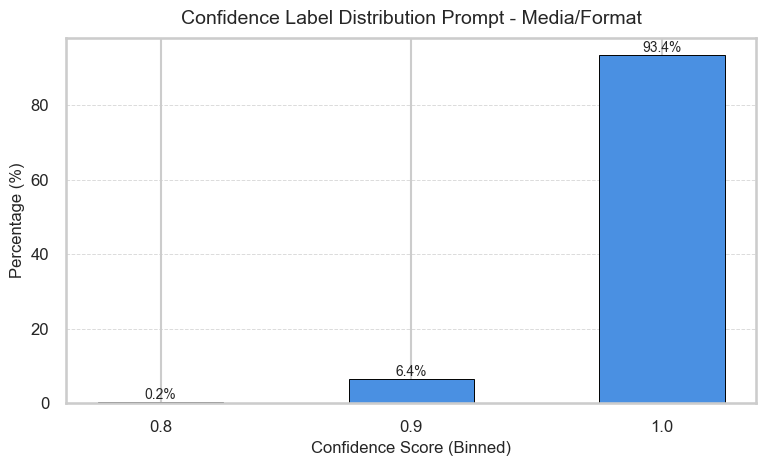

In [44]:
prompt_media_format_confidence = dataset.get_confidence_distribution(
    name="prompt_media_format",
    level="message",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(prompt_media_format_confidence)
plot_confidence_distribution(prompt_media_format_confidence, "Prompt", "Media/Format", "confidence_prompt_media_format")

{'0.8': 7, '0.9': 273, '1.0': 10116}


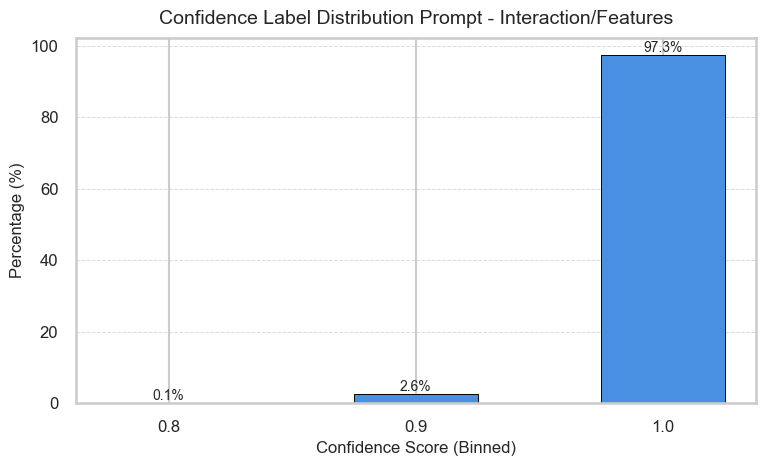

In [46]:
prompt_interaction_features_confidence = dataset.get_confidence_distribution(
    name="prompt_interaction_features",
    level="message",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(prompt_interaction_features_confidence)
plot_confidence_distribution(prompt_interaction_features_confidence, "Prompt", "Interaction/Features", "confidence_prompt_interaction_features")

{'0.7': 3, '0.8': 23, '0.9': 2290, '1.0': 7871}


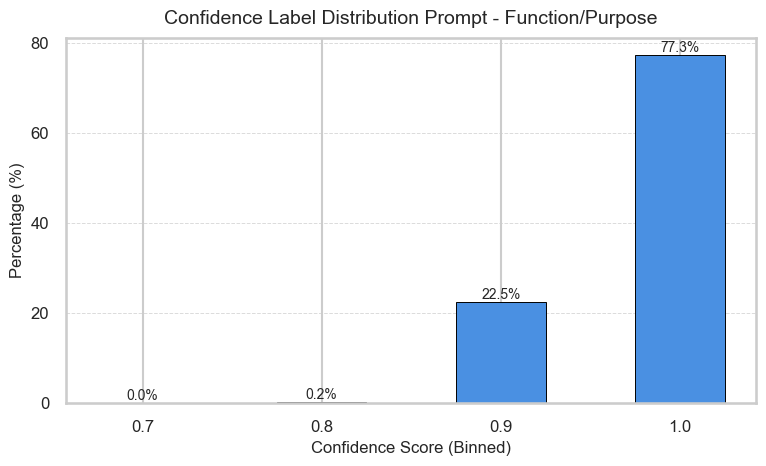

In [47]:
prompt_function_purpose_confidence = dataset.get_confidence_distribution(
    name="prompt_function_purpose",
    level="message",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(prompt_function_purpose_confidence)
plot_confidence_distribution(prompt_function_purpose_confidence, "Prompt", "Function/Purpose", "confidence_prompt_function_purpose")

{'0.5': 5, '0.6': 1, '0.7': 7, '0.8': 25, '0.9': 1110, '1.0': 8973}


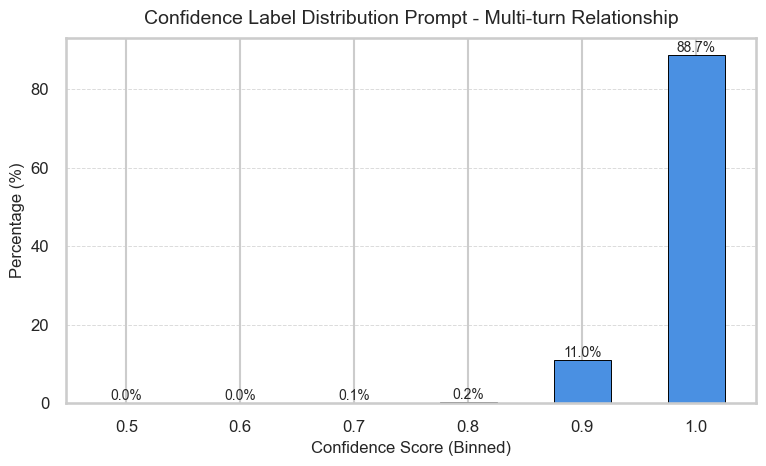

In [48]:
prompt_multi_turn_relationship_confidence = dataset.get_confidence_distribution(
    name="prompt_multi_turn_relationship",
    level="message",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(prompt_multi_turn_relationship_confidence)
plot_confidence_distribution(prompt_multi_turn_relationship_confidence, "Prompt", "Multi-turn Relationship", "confidence_prompt_multi_turn_relationship")

{'0.8': 13, '0.9': 425, '1.0': 14398}


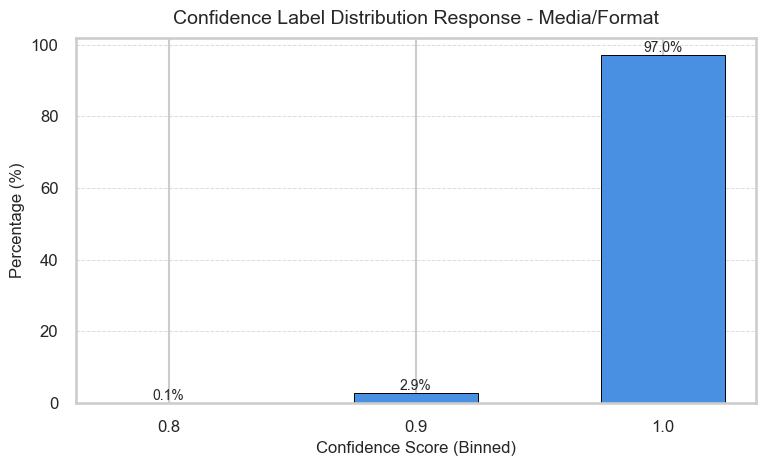

In [49]:
response_media_format_confidence = dataset.get_confidence_distribution(
    name="response_media_format",
    level="message",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(response_media_format_confidence)
plot_confidence_distribution(response_media_format_confidence, "Response", "Media/Format", "confidence_response_media_format")

{'0.7': 1, '0.8': 63, '0.9': 914, '1.0': 10051}


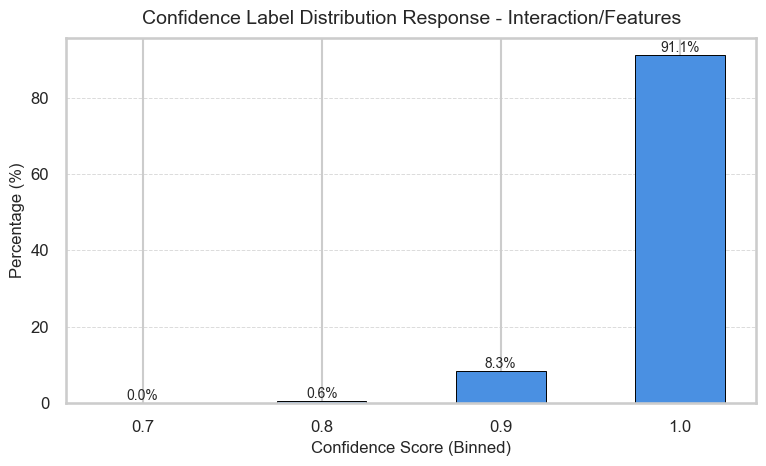

In [50]:
response_interaction_features_confidence = dataset.get_confidence_distribution(
    name="response_interaction_features",
    level="message",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(response_interaction_features_confidence)
plot_confidence_distribution(response_interaction_features_confidence, "Response", "Interaction/Features", "confidence_response_interaction_features")

{'0.5': 3, '0.6': 11, '0.7': 48, '0.8': 421, '0.9': 4127, '1.0': 8176}


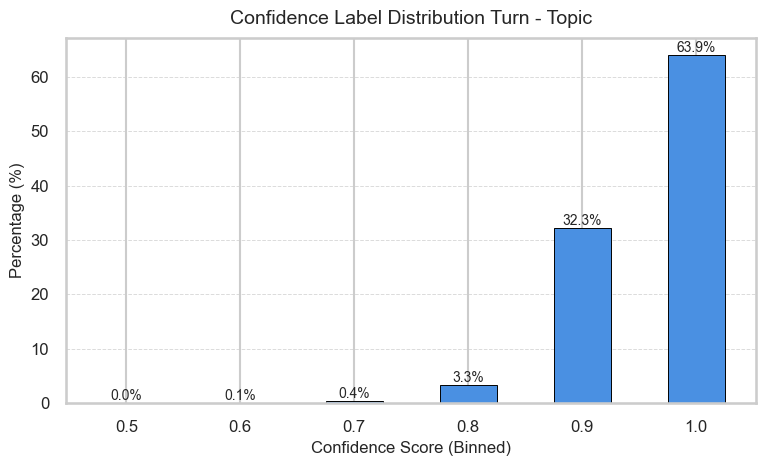

In [51]:
turn_topic_confidence = dataset.get_confidence_distribution(
    name="turn_topic",
    level="message",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(turn_topic_confidence)
plot_confidence_distribution(turn_topic_confidence, "Turn", "Topic", "confidence_turn_topic")

{'0.8': 9, '0.9': 334, '1.0': 9850}


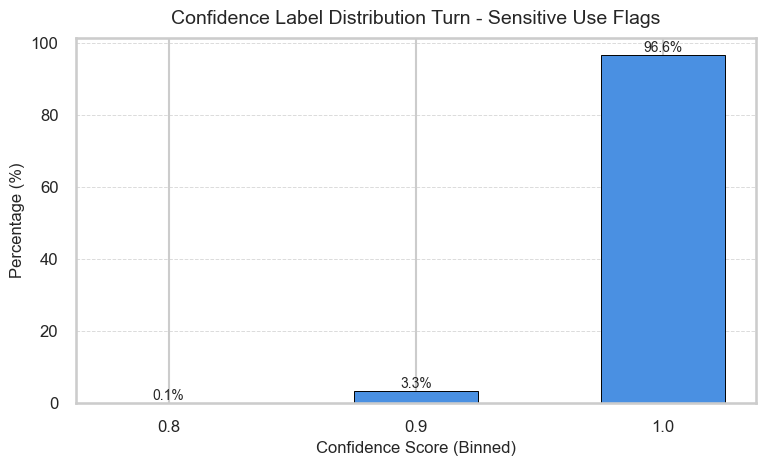

In [52]:
turn_sensitive_use_flags_confidence = dataset.get_confidence_distribution(
    name="turn_sensitive_use_flags",
    level="message",
    annotation_source="automatic_v0",
    bin_size=0.1
)
print(turn_sensitive_use_flags_confidence)
plot_confidence_distribution(turn_sensitive_use_flags_confidence, "Turn", "Sensitive Use Flags", "confidence_turn_sensitive_use_flags")